In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from tqdm.auto import tqdm

In [2]:
from darts import TimeSeries
from darts.metrics import mape, mase, rmse, mae, smape, mse

from darts.utils.missing_values import fill_missing_values

## MODWT functions

In [3]:
import numpy as np
import pdb
import pywt


def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2 ** (j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2 ** (j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
        Modification of 
            https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
    '''
    return np.flip(np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(np.flip(ker))))).astype(np.int).tolist()


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2 ** ((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2 ** ((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)

## Prepare Dataset

In [4]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "dyt" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
# param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False



In [5]:
import sys
sys.path.insert(0, '../Datasets')
from PJM_energy_datasets.dayton_def import DAYTON

In [6]:
full_set = DAYTON(path = "../Datasets/PJM_energy_datasets/",
                  seq_len = param_dset_lookback,
                  pred_horz = param_dset_forecast,
                  timestamp = False)
dytmax = full_set.max()
dytmin = full_set.min()
del(full_set)

train_set = DAYTON(path = "../Datasets/PJM_energy_datasets/",
                start_idx = 0, end_idx = 97036,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=29,
                timestamp = False)
val_set = DAYTON(path = "../Datasets/PJM_energy_datasets/",
              start_idx = 97036, end_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)
test_set = DAYTON(path = "../Datasets/PJM_energy_datasets/",
                start_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)


train_set.series = (train_set.series - dytmin)/(dytmax - dytmin)
val_set.series = (val_set.series - dytmin)/(dytmax - dytmin)
test_set.series = (test_set.series - dytmin)/(dytmax - dytmin)

print(train_set.series.shape)

torch.Size([3318, 840, 1])


## Import Models for comparison

In [7]:
#Importing the testing models
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    VARIMA,
    BATS,
    TBATS,
    StatsForecastAutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FourTheta,
    FFT,
    NBEATSModel,
    TFTModel,
    RNNModel,
    TransformerModel,
)

In [8]:
def eval_model(model, train, val, f=None ):
    model.fit(train)
    forecast = model.predict(len(val))
    mseRes = mse(val, forecast)
    rmseRes = rmse(val, forecast)
    # mapeRes = mape(val, forecast)
    maeRes = mae(val, forecast)
    smapeRes = smape(val, forecast)
    # maseRes = mase(val, forecast,train)
    
    # print('model {} obtains MSE: {:.6f}'.format(model,mseRes))
    # print('model {} obtains RMSE: {:.6f}'.format(model,rmseRes))
    # # print('model {} obtains MAPE: {:.6f}'.format(model,mapeRes ))
    # print('model {} obtains MAE: {:.6f}'.format(model, maeRes))
    # print('model {} obtains SMAPE: {:.6f}'.format(model,smapeRes ))
    # print('model {} obtains MASE: {:.6f}'.format(model,maseRes ))

    return forecast, mseRes, rmseRes, maeRes, smapeRes

## Prepare Data

In [9]:
train_set_squeeze = train_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
train_np = train_set_squeeze.numpy()
# print((type(train_np)))

test_set_squeeze = test_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
test_np = test_set_squeeze.numpy()

test_np = test_np[:]

In [10]:
# train_series = np.nan_to_num(train_np[:100])
train_series = np.nan_to_num(test_np)

series_Lists = []
train_set_series = []
test_set_series = []
val_set_series = []

for i in tqdm(range(len(train_series)), total=len(train_series), desc="Series Conversion", position=1, leave=True):
    seriesList = []
    train = []
    test = []
    val = []
    nb_time = len(train_series[i])
    # nb_val = int(nb_time*0.2)
    
    wt = modwt(train_series[i], 'db2', int(np.log(len(train_series[i]))))
    for j in range(len(wt)):
        
        wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[j]))
        seriesList.append(wt_df)
        
        wt_df_train = wt_df[:nb_time-param_dset_forecast]
        train.append(wt_df_train)
        
        #wt_df_test = wt_df[nb_time-nforecast-nb_val:nb_time-nforecast]
        #test.append(wt_df_test)
        
        wt_df_val = wt_df[nb_time-param_dset_forecast:]
        val.append(wt_df_val)

    series_Lists.append(seriesList)
    train_set_series.append(train)
    # test_set_series.append(test)
    val_set_series.append(val)


Series Conversion:   0%|          | 0/471 [00:00<?, ?it/s]

In [11]:
# series = train_np[0]
# wt = modwt(series, 'haar', int(np.log(len(series))))
# seriesList = []
# train = []
# test = []
# val = []
# nb_time = len(series)
# # nb_val = int(nb_time*0.2)
# # print(wt)

# for i in range(len(wt)):
#     # print(wt[i])
#     wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[i]))
#     seriesList.append(wt_df)
    
#     wt_df_train = wt_df[:nb_time-param_dset_forecast]
#     train.append(wt_df_train)
    
#     #wt_df_test = wt_df[nb_time-nforecast-nb_val:nb_time-nforecast]
#     #test.append(wt_df_test)
    
#     wt_df_val = wt_df[nb_time-param_dset_forecast:]
#     val.append(wt_df_val)

# print(len(train))
# print(len(train[0]))

In [12]:
print(len(train_set_series))
print(len(train_set_series[0]))
print(len(train_set_series[0][0]))

print(type(train_set_series))
print(type(train_set_series[0]))
print(type(train_set_series[0][0]))

test = train_set_series[0][0]
print(len(test))

471
7
816
<class 'list'>
<class 'list'>
<class 'darts.timeseries.TimeSeries'>
816


In [13]:
# Due to TimeSeries object, cannot use np.array
# Current shape: 100,7,816 -> 7 * 100,816
train_emb = []
Series_List_emb = []

for i in range(len(train_set_series[0])):
    train_emb_temp = [t[i] for t in train_set_series]
    train_emb.append(train_emb_temp)

for i in range(len(series_Lists[0])):
    series_temp = [s[i] for s in series_Lists]
    Series_List_emb.append(series_temp)

print(len(train_emb))
print(len(Series_List_emb[0]))

7
471


In [14]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 2 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=1,
    min_delta=0.0,
    mode='min',
)

# No need for early stopping for historical forecast since it use training set to forecast

# Train models based on different values of wavelet transform
prediction = []
models_transformers = []
for i in range(len(train_emb)):
    transformers = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=64,
    n_epochs=4,
    model_name="transformer"+str(i),
    nr_epochs_val_period=1,
    #d_model=16,
    #nhead=8,
    d_model=64,
    nhead=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    # pl_trainer_kwargs = {"accelerator": "gpu", 
    #                    "gpus": -1, 
    #                    "auto_select_gpus": True},
    # pl_trainer_kwargs = {"callbacks": [my_stopper]}
    )
    
    transformers.fit(series = train_emb[i], verbose=True)
    # print('seriesList = ', Series_List_emb[i])
    print('nb-time-nforecast = ',nb_time-param_dset_forecast)
    
    pred_series = transformers.historical_forecasts(Series_List_emb[i],
                                                    start = nb_time-param_dset_forecast, #the first point in time at which a prediction is computed
                                                    retrain=False,
                                                    verbose=True,
                                                    )
    prediction.append(pred_series)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

C:\Users\Andrew Ng\anaconda3\envs\swt_env\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:383: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 167 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.671     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  816


Predicting: |                                                                                    | 0/? [00:00<…

In [15]:
# Due to TimeSeries object, cannot use np.array
# Current shape: 7 * 100,816-> 100,7,816
new_pred = []

for i in range(len(prediction[0])):
    pred_temp = [t[i] for t in prediction]
    new_pred.append(pred_temp)

print(len(new_pred))
print(len(new_pred[0]))

471
7


In [45]:
full_result = []

for series_num in range(len(new_pred)):
    prediction_tmp = new_pred[series_num][0].pd_dataframe()
    
    for i in range(1,len(new_pred[series_num])):
        prediction_tmp[i] = new_pred[series_num][i].pd_dataframe()
    
    res = imodwt(prediction_tmp.transpose().to_numpy(),'db2')
    full_result.append(TimeSeries.from_values(res))

In [46]:
test_actual = test_set_squeeze.numpy()
test_actual_series = np.nan_to_num(test_actual[:,param_dset_lookback:])

actual = []
for i in range(len(test_actual_series)):
    actual.append(TimeSeries.from_values(test_actual_series[i]))

pred = full_result
print(np.mean(mse(actual,pred)), np.mean(rmse(actual,pred)),np.mean(mae(actual,pred)), np.mean(smape(actual,pred))) #, mape(actual,pred)

0.010397457781390453 0.08647629657145725 0.08075695604018025 23.196672618598342


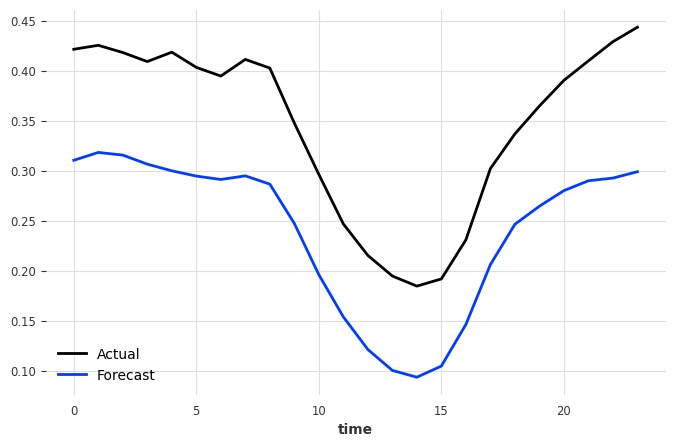

In [47]:
plt.figure(figsize=(8, 5))
actual[1].plot(label="Actual")
pred[1].plot(label="Forecast")
plt.legend()